#Data collection and Data Cleaning

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, mean, isnan, round as spark_round
from pyspark.sql.types import DoubleType, IntegerType

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()
df_bridgedata = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/sshah62@gmu.edu/Team_4.csv")

In [0]:
df_bridgedata.show()

+----+--------------+--------------------+-------------------------+--------------------+-----------------+----------------------------+---------------+--------------------------+------------------------+----------------------+---------------------------------+---------------------------+---------------------------------+------------------------+---------------+--------------------------+------------------------------------+----------------------------------+---------------------------------+-------------------------+-------------------+-------------------+---------------+-------------------+----------------------------+-----------------------+--------------------------------------------+-----------------------------------------+-------------------------+---------------+-------------------+-----------------------------------------------+-------------------------------+-------------------------------+
|Year|1 - State Name|8 - Structure Number|2024 NBI Structure Number|   22 - Owner Agen

In [0]:
column_names = df_bridgedata.columns
print(column_names)

['Year', '1 - State Name', '8 - Structure Number', '2024 NBI Structure Number', '22 - Owner Agency', '3 - County Name', 'City - InfoBridge Place Code', '27 - Year Built', '29 - Average Daily Traffic', '43A - Main Span Material', '43B - Main Span Design', '45 - Number of Spans in Main Unit', '49 - Structure Length (ft.)', '7 - Facility Carried By Structure', 'CAT10 - Bridge Condition', 'Bridge Age (yr)', '58 - Deck Condition Rating', '59 - Superstructure Condition Rating', '60 - Substructure Condition Rating', '113 - Scour Critical Bridge Value', 'Average Relative Humidity', 'Average Temperature', 'Maximum Temperature', 'Mean Wind Speed', 'Minimum Temperature', 'Number of Freeze-Thaw Cycles', 'Number of Snowfall Days', 'Number of Days with Measurable Precipitation', 'Number of Days with Temperature Below 0?C', 'Prevailing Wind Direction', 'Time of Wetness', 'Total Precipitation', 'Computed - Average Daily Truck Traffic (Volume)', '64 - Operating Rating (US tons)', '66 - Inventory Rating

In [0]:
# to clean column names
def clean_column_name(col_name):
    # Strip leading and trailing spaces
    cleaned_name = col_name.strip()
    # Remove dashes, digits, and "CAT10" references
    cleaned_name = cleaned_name.replace("CAT10 - ", "").replace("-", "").strip()
    cleaned_name = ''.join([c for c in cleaned_name if not c.isdigit()])
    # Replace the question mark with "0°C"
    cleaned_name = cleaned_name.replace("?C", "0C")
    # Remove blank spaces and replace with underscores
    cleaned_name = cleaned_name.replace(" ", "_")
    # Replace periods with blanks
    cleaned_name = cleaned_name.replace(".", "")
    # Remove any additional spaces from the name
    cleaned_name = ' '.join(cleaned_name.split())
    # Remove any trailing or leading underscores explicitly
    cleaned_name = cleaned_name.strip("_")
    return cleaned_name

# Apply cleaning to all column names
cleaned_columns = [clean_column_name(col_name) for col_name in df_bridgedata.columns]

# Rename columns in the DataFrame
df_bridgedata = df_bridgedata.toDF(*cleaned_columns)

# Display cleaned column names to verify
print("Cleaned column names:", df_bridgedata.columns)


Cleaned column names: ['Year', 'State_Name', 'Structure_Number', 'NBI_Structure_Number', 'Owner_Agency', 'County_Name', 'City__InfoBridge_Place_Code', 'Year_Built', 'Average_Daily_Traffic', 'A__Main_Span_Material', 'B__Main_Span_Design', 'Number_of_Spans_in_Main_Unit', 'Structure_Length_(ft)', 'Facility_Carried_By_Structure', 'Bridge_Condition', 'Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 'Substructure_Condition_Rating', 'Scour_Critical_Bridge_Value', 'Average_Relative_Humidity', 'Average_Temperature', 'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature', 'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Number_of_Days_with_Measurable_Precipitation', 'Number_of_Days_with_Temperature_Below_0C', 'Prevailing_Wind_Direction', 'Time_of_Wetness', 'Total_Precipitation', 'Computed__Average_Daily_Truck_Traffic_(Volume)', 'Operating_Rating_(US_tons)', 'Inventory_Rating_(US_tons)']


In [0]:
df_bridgedata.columns

Out[58]: ['Year',
 'State_Name',
 'Structure_Number',
 'NBI_Structure_Number',
 'Owner_Agency',
 'County_Name',
 'City__InfoBridge_Place_Code',
 'Year_Built',
 'Average_Daily_Traffic',
 'A__Main_Span_Material',
 'B__Main_Span_Design',
 'Number_of_Spans_in_Main_Unit',
 'Structure_Length_(ft)',
 'Facility_Carried_By_Structure',
 'Bridge_Condition',
 'Bridge_Age_(yr)',
 'Deck_Condition_Rating',
 'Superstructure_Condition_Rating',
 'Substructure_Condition_Rating',
 'Scour_Critical_Bridge_Value',
 'Average_Relative_Humidity',
 'Average_Temperature',
 'Maximum_Temperature',
 'Mean_Wind_Speed',
 'Minimum_Temperature',
 'Number_of_FreezeThaw_Cycles',
 'Number_of_Snowfall_Days',
 'Number_of_Days_with_Measurable_Precipitation',
 'Number_of_Days_with_Temperature_Below_0C',
 'Prevailing_Wind_Direction',
 'Time_of_Wetness',
 'Total_Precipitation',
 'Computed__Average_Daily_Truck_Traffic_(Volume)',
 'Operating_Rating_(US_tons)',
 'Inventory_Rating_(US_tons)']

In [0]:
# Check for missing values in each column
from pyspark.sql.functions import col, count, when

null_counts = df_bridgedata.select([count(when(col(c).isNull(), c)).alias(c) for c in df_bridgedata.columns])
null_counts.show()

+----+----------+----------------+--------------------+------------+-----------+---------------------------+----------+---------------------+---------------------+-------------------+----------------------------+---------------------+-----------------------------+----------------+---------------+---------------------+-------------------------------+-----------------------------+---------------------------+-------------------------+-------------------+-------------------+---------------+-------------------+---------------------------+-----------------------+--------------------------------------------+----------------------------------------+-------------------------+---------------+-------------------+----------------------------------------------+--------------------------+--------------------------+
|Year|State_Name|Structure_Number|NBI_Structure_Number|Owner_Agency|County_Name|City__InfoBridge_Place_Code|Year_Built|Average_Daily_Traffic|A__Main_Span_Material|B__Main_Span_Design|Numb

In [0]:
# Drop columns with more than 50% missing values
row_count = df_bridgedata.count()
columns_to_drop = [
    cleaned_columns
    for cleaned_columns in df_bridgedata.columns
    if df_bridgedata.filter(col(f"{cleaned_columns}").isNull() | isnan(col(f"{cleaned_columns}"))).count() > row_count * 0.5
]
df_bridgedata = df_bridgedata.drop(*[f"{col}" for col in columns_to_drop])
# Drop the 'NBI Structure Number' column
df_bridgedata = df_bridgedata.drop('NBI_Structure_Number')

# Verify that the columns are dropped
#df_bridgedata.printSchema()
display(df_bridgedata)


Year,State_Name,Structure_Number,Owner_Agency,County_Name,Year_Built,Average_Daily_Traffic,A__Main_Span_Material,B__Main_Span_Design,Number_of_Spans_in_Main_Unit,Structure_Length_(ft),Facility_Carried_By_Structure,Bridge_Condition,Bridge_Age_(yr),Deck_Condition_Rating,Superstructure_Condition_Rating,Substructure_Condition_Rating,Scour_Critical_Bridge_Value,Average_Relative_Humidity,Average_Temperature,Maximum_Temperature,Mean_Wind_Speed,Minimum_Temperature,Number_of_FreezeThaw_Cycles,Number_of_Snowfall_Days,Number_of_Days_with_Measurable_Precipitation,Number_of_Days_with_Temperature_Below_0C,Prevailing_Wind_Direction,Time_of_Wetness,Total_Precipitation,Computed__Average_Daily_Truck_Traffic_(Volume),Operating_Rating_(US_tons),Inventory_Rating_(US_tons)
2000,Maryland,100000070042010,State Highway Agency,Cecil County,1973,6575,Steel,Stringer/Multi-beam or Girder,2,90.9,MD 273,Fair,27,6,6,6,Foundations stable; Scour above top of footing,77,11.7,32.6,3,-16.6,76,27,114,100,152.4,3676,1293.33,526,35.7,35.7
2000,Delaware,1806 060,State Highway Agency,New Castle County,1975,17498,Steel Continuous,Stringer/Multi-beam or Girder,2,222.1,I 495 SB,Fair,25,7,5,5,Bridge not over waterway,77,11.7,32.6,3,-16.6,76,27,114,100,152.4,3676,1293.33,875,64.0,38.0
2000,Florida,790174,State Highway Agency,Volusia County,1997,11500,Prestressed Concrete Continuous,Segmental Box Girder,10,2319.9,SR 430,Good,3,7,7,8,"""Not Evaluated; Over """"""""Tidal"""""""" waters""",71,21.9,38.8,2,-4.5,5,0,96,5,187.03,3526,819.08,230,0.0,0.0
2000,California,24 0287L,State Highway Agency,Sacramento County,1975,20800,Prestressed Concrete Continuous,Box Beam or Girders - Multiple,2,258.9,INTERSTATE 5 SB,Good,25,7,8,7,Bridge not over waterway,60,16.3,44.2,2,-0.1,1,0,68,1,135.98,2368,875.96,3744,110.1,35.9
2000,Delaware,1281 366,State Highway Agency,New Castle County,1980,23721,Steel Continuous,Stringer/Multi-beam or Girder,2,274.9,SR 4 & SR 896,Good,20,7,7,7,Foundations stable; Scour above top of footing,77,11.7,32.6,3,-16.6,76,27,114,100,152.4,3676,1293.33,1660,99.0,57.0
2000,Delaware,1305N082,State Highway Agency,New Castle County,1994,16135,Prestressed Concrete,Stringer/Multi-beam or Girder,1,75.1,DUPONT HWY,Good,6,7,8,9,Foundations stable; Scour above top of footing,77,11.7,32.6,3,-16.6,76,27,114,100,152.4,3676,1293.33,807,99.0,72.0
2000,Delaware,2920N150,State Highway Agency,Kent County,1992,12324,Steel,Stringer/Multi-beam or Girder,1,71.9,SR 1,Good,8,7,8,7,Bridge not over waterway,78,12.2,32.3,3,-15.1,75,22,109,93,151.23,3813,1280.96,1109,75.0,55.0
2000,Mississippi,11000100240460B,State Highway Agency,Harrison County,1970,13465,Prestressed Concrete,Stringer/Multi-beam or Girder,1,422.9,I 10,Good,30,7,7,8,Bridge not over waterway,71,21.1,38.3,3,-3.4,7,0,100,7,181.38,3064,1000.51,673,68.7,65.7
2000,New York,000000001016310,State Highway Agency,Steuben County,1990,6476,Prestressed Concrete,Box Beam or Girders - Multiple,2,176.8,MAIN ST,Good,10,7,7,8,Foundations stable; Scour above top of footing,78,7.3,32.1,0,-20.6,91,106,141,154,142.13,3175,1126.11,453,84.0,49.9
2000,Mississippi,310004306412140,State Highway Agency,Simpson County,1963,2200,Steel,Stringer/Multi-beam or Girder,3,182.1,SR 43,Good,37,7,7,7,Evaluation not yet made,70,18.7,41.7,0,-6.7,43,8,92,44,152.35,3488,989.04,176,54.5,32.6


In [0]:
from pyspark.sql.functions import mean, when, lit, col, round as spark_round, isnan
from pyspark.sql.types import DoubleType, IntegerType

# Identify numeric columns in the DataFrame
numeric_cols = [field.name for field in df_bridgedata.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# Fill missing values in numeric columns with the mean (rounded to 2 decimal places)
for col_name in numeric_cols:
    # Calculate mean of the column
    mean_value = df_bridgedata.select(mean(col(col_name)).alias('mean')).collect()[0]['mean']
    
    # If mean is calculated (i.e., not None), fill missing values with rounded mean
    if mean_value is not None:
        # Replace missing values with the mean
        df_bridgedata = df_bridgedata.withColumn(
            col_name,
            when(col(col_name).isNull() | isnan(col(col_name)), spark_round(lit(mean_value), 2)).otherwise(col(col_name))
        )
        
        # Check the original data type
        original_type = df_bridgedata.schema[col_name].dataType
        # Cast back to IntegerType if it was originally an integer column
        if isinstance(original_type, IntegerType):
            df_bridgedata = df_bridgedata.withColumn(col_name, col(col_name).cast('int'))

In [0]:
# Fill missing categorical columns with "Unknown"
categorical_cols = [field.name for field in df_bridgedata.schema.fields if field.dataType == "string"]
for col_name in categorical_cols:
    df_bridgedata = df_bridgedata.withColumn(col_name, when(col(f'{col_name}').isNull(), lit("Unknown")).otherwise(col(f"{col_name}")))

In [0]:
df_bridgedata = df_bridgedata.dropDuplicates()

In [0]:
# Check for missing values in each column
from pyspark.sql.functions import col, count, when

null_counts = df_bridgedata.select([count(when(col(c).isNull(), c)).alias(c) for c in df_bridgedata.columns])
null_counts.show()# Check for missing values in each column
from pyspark.sql.functions import col, count, when

null_counts = df_bridgedata.select([count(when(col(c).isNull(), c)).alias(c) for c in df_bridgedata.columns])
null_counts.show()

+----+----------+----------------+------------+-----------+----------+---------------------+---------------------+-------------------+----------------------------+---------------------+-----------------------------+----------------+---------------+---------------------+-------------------------------+-----------------------------+---------------------------+-------------------------+-------------------+-------------------+---------------+-------------------+---------------------------+-----------------------+--------------------------------------------+----------------------------------------+-------------------------+---------------+-------------------+----------------------------------------------+--------------------------+--------------------------+
|Year|State_Name|Structure_Number|Owner_Agency|County_Name|Year_Built|Average_Daily_Traffic|A__Main_Span_Material|B__Main_Span_Design|Number_of_Spans_in_Main_Unit|Structure_Length_(ft)|Facility_Carried_By_Structure|Bridge_Condition|Brid

In [0]:
# Create a temporary SQL view
df_bridgedata.createOrReplaceTempView("cleaned_table")

In [0]:
# Use Spark SQL to display the table
print("Displaying table using SQL:")
spark.sql("SELECT * FROM cleaned_table").show(truncate=False)  # Full table display

Displaying table using SQL:
+------+------------+----------------+--------------------+-----------------+----------+---------------------+-------------------------------+------------------------------+----------------------------+---------------------+-----------------------------+----------------+---------------+---------------------+-------------------------------+-----------------------------+----------------------------------------------+-------------------------+-------------------+-------------------+---------------+-------------------+---------------------------+-----------------------+--------------------------------------------+----------------------------------------+-------------------------+---------------+-------------------+----------------------------------------------+--------------------------+--------------------------+
|Year  |State_Name  |Structure_Number|Owner_Agency        |County_Name      |Year_Built|Average_Daily_Traffic|A__Main_Span_Material          |B__Main_

In [0]:
df_bridgedata.groupBy("Bridge_Condition").count().show()

+----------------+-----+
|Bridge_Condition|count|
+----------------+-----+
|            null|    1|
|            Good|  410|
|            Fair|  495|
|            Poor|   11|
+----------------+-----+



In [0]:
from pyspark.sql.functions import mean, col, when, lit, round as spark_round

for col_name in numeric_cols:
    # Calculate Q1, Q3, and IQR
    quantiles = df_bridgedata.approxQuantile(f"`{col_name}`", [0.25, 0.75], 0.05)
    if len(quantiles) == 2 and quantiles[0] is not None:
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate the mean value of the column
        mean_value = df_bridgedata.select(mean(col(f"{col_name}"))).collect()[0][0]

        # Replace outliers with the mean value
        df_bridgedata = df_bridgedata.withColumn(
            col_name,
            when((col(f"`{col_name}`") < lower_bound) | (col(f"`{col_name}`") > upper_bound),
                 spark_round(lit(mean_value), 2)
            ).otherwise(col(f"`{col_name}`"))
        )

In [0]:
df_bridgedata.show()

+------+------------+----------------+--------------------+-----------------+----------+---------------------+---------------------+--------------------+----------------------------+---------------------+-----------------------------+----------------+---------------+---------------------+-------------------------------+-----------------------------+---------------------------+-------------------------+-------------------+-------------------+---------------+-------------------+---------------------------+-----------------------+--------------------------------------------+----------------------------------------+-------------------------+---------------+-------------------+----------------------------------------------+--------------------------+--------------------------+
|  Year|  State_Name|Structure_Number|        Owner_Agency|      County_Name|Year_Built|Average_Daily_Traffic|A__Main_Span_Material| B__Main_Span_Design|Number_of_Spans_in_Main_Unit|Structure_Length_(ft)|Facility_Carr

#EDA

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


spark = SparkSession.builder.appName("Bridge Maintenance Prioritization").getOrCreate()

In [0]:
# summary statistics for numerical columns 
df_bridgedata = df_bridgedata.filter(df_bridgedata['Bridge_Condition'].isNotNull())
df_bridgedata.describe().display()

summary,Year,State_Name,Structure_Number,Owner_Agency,County_Name,Year_Built,Average_Daily_Traffic,A__Main_Span_Material,B__Main_Span_Design,Number_of_Spans_in_Main_Unit,Structure_Length_(ft),Facility_Carried_By_Structure,Bridge_Condition,Bridge_Age_(yr),Deck_Condition_Rating,Superstructure_Condition_Rating,Substructure_Condition_Rating,Scour_Critical_Bridge_Value,Average_Relative_Humidity,Average_Temperature,Maximum_Temperature,Mean_Wind_Speed,Minimum_Temperature,Number_of_FreezeThaw_Cycles,Number_of_Snowfall_Days,Number_of_Days_with_Measurable_Precipitation,Number_of_Days_with_Temperature_Below_0C,Prevailing_Wind_Direction,Time_of_Wetness,Total_Precipitation,Computed__Average_Daily_Truck_Traffic_(Volume),Operating_Rating_(US_tons),Inventory_Rating_(US_tons)
count,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916,916
mean,2012.3176855895197,null,5.476682639700562E13,null,null,1980.7975109170306,15809.534858078607,null,null,2.020469432314411,200.83444323144067,null,null,31.666681222707425,6.837237991266377,6.813318777292577,6.88646288209607,null,76.74311135371156,12.964475982532857,36.125589519650646,1.8132641921397339,-12.214301310043691,68.92737991266368,24.033187772925736,122.32895196506519,83.43641921397368,157.12945414847164,3795.1904803493426,1280.8574563318803,1003.5040283842785,79.22141921397386,48.68863537117892
stddev,7.1340447140393,null,1.274004162458239E14,null,null,13.544139132331235,12613.664696970016,null,null,0.7302508724880193,84.2980890682819,null,null,14.861742924171828,0.8461619631538753,1.0829415067366968,0.9628010932008974,null,2.2800414224599628,1.345497429080772,2.465326230456846,1.0298752325437814,5.1380792750775965,29.860375464056293,15.548959485567792,13.459356482878711,40.371494063959396,9.894545957330246,549.1916791757087,196.03628956947608,1032.3146918387092,21.07192968657288,15.730115212033262
min,2000.0,California,790174,State Highway Agency,Allegany County,1948.0,50.0,Prestressed Concrete,Box Beam or Girders - Multiple,1.0,71.9,CHRISTINA PARKWAY,Fair,1.0,5.0,4.0,5.0,"""Not Evaluated; Over """"""""Tidal"""""""" waters""",71.0,8.4,29.0,0.0,-25.8,0.0,0.0,82.0,0.0,130.0,2166.0,745.99,0.0,31.7,0.0
max,2024.0,West Virginia,5718,State Highway Agency,Volusia County,2008.0,55933.0,Steel Continuous,Truss - Thru,3.0,422.9,WEST BANGS AVENUE,Poor,75.0,8.0,9.0,9.0,Foundations stable; Scour above top of footing,82.0,17.1,43.1,4.0,1.0,124.0,75.0,157.0,191.0,182.26,5238.0,1770.76,4020.0,110.1,85.4


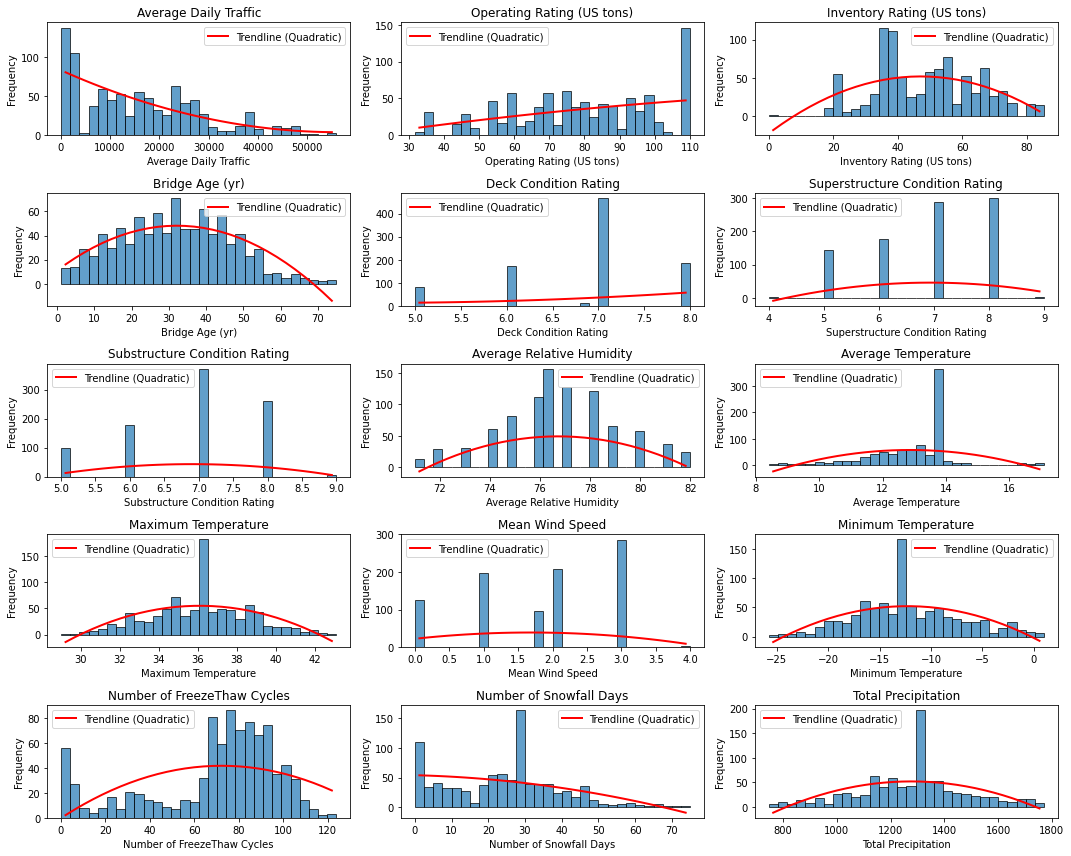

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F

# Naming our numerical columns for our EDA and setting up for subplots
cols_with_num = [
    'Average_Daily_Traffic', 'Operating_Rating_(US_tons)', 'Inventory_Rating_(US_tons)', 
    'Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 
    'Substructure_Condition_Rating', 'Average_Relative_Humidity', 'Average_Temperature', 
    'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature', 
    'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Total_Precipitation'
]


numeric_cols = len(cols_with_num)


cols = 3
rows = (numeric_cols // cols) + (numeric_cols % cols > 0)


fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

# Repeat through numerical columns to plot histograms and add trend lines
for i, col in enumerate(cols_with_num):
    
    column_data = df_bridgedata.select(col).dropna().rdd.flatMap(lambda x: x).collect()

    # Plot
    counts, bin_edges, _ = axes[i].hist(column_data, bins=30, edgecolor='black', alpha=0.7)

    # Fit a line
    # Using midpoints for fitting the line
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    #linear line
    poly_coeffs = np.polyfit(bin_centers, counts, deg=2)  # 2-degree polynomial (quadratic)
    poly_eqn = np.poly1d(poly_coeffs)

    # Produce values for fitted line
    trendline_values = poly_eqn(bin_centers)

    # Plotting the line over histogram
    axes[i].plot(bin_centers, trendline_values, color='red', lw=2, label='Trendline (Quadratic)')

    # Giving title and labels
    axes[i].set_title(col.replace('_', ' '))
    axes[i].set_xlabel(col.replace('_', ' '))
    axes[i].set_ylabel("Frequency")

    # Add legend to our chart
    axes[i].legend()

# Removing empty subplots if there are more axes in the grid than required
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [0]:
# Below are categorical columns
cols_cat = [
    'State_Name', 'Owner_Agency', 'County_Name', 
    'A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 
    'Bridge_Condition', 'Scour_Critical_Bridge_Value', 'Prevailing_Wind_Direction', 'Time_of_Wetness'
]

# Loop through categorical columns to get value counts for each
for col in cols_cat:
    print(f"\nValue counts for '{col}':")
    # Group by the categorical column and count
    value_counts_df = df_bridgedata.groupBy(col).count().orderBy('count', ascending=False) 
    value_counts_df.show()
    print("-" * 50)


Value counts for 'State_Name':
+-------------+-----+
|   State_Name|count|
+-------------+-----+
|     Virginia|  175|
|  Mississippi|  172|
| Pennsylvania|  148|
|   New Jersey|  148|
|     Delaware|  115|
|     Maryland|   42|
|    Minnesota|   25|
|      Florida|   25|
|   California|   25|
|     New York|   25|
|West Virginia|   16|
+-------------+-----+

--------------------------------------------------

Value counts for 'Owner_Agency':
+--------------------+-----+
|        Owner_Agency|count|
+--------------------+-----+
|State Highway Agency|  916|
+--------------------+-----+

--------------------------------------------------

Value counts for 'County_Name':
+--------------------+-----+
|         County_Name|count|
+--------------------+-----+
|   New Castle County|   90|
|        Hinds County|   75|
|     Monmouth County|   75|
|     Harrison County|   50|
|Prince William Co...|   50|
|    Arlington County|   50|
|   Gloucester County|   50|
|      Fairfax County|   50|
|  

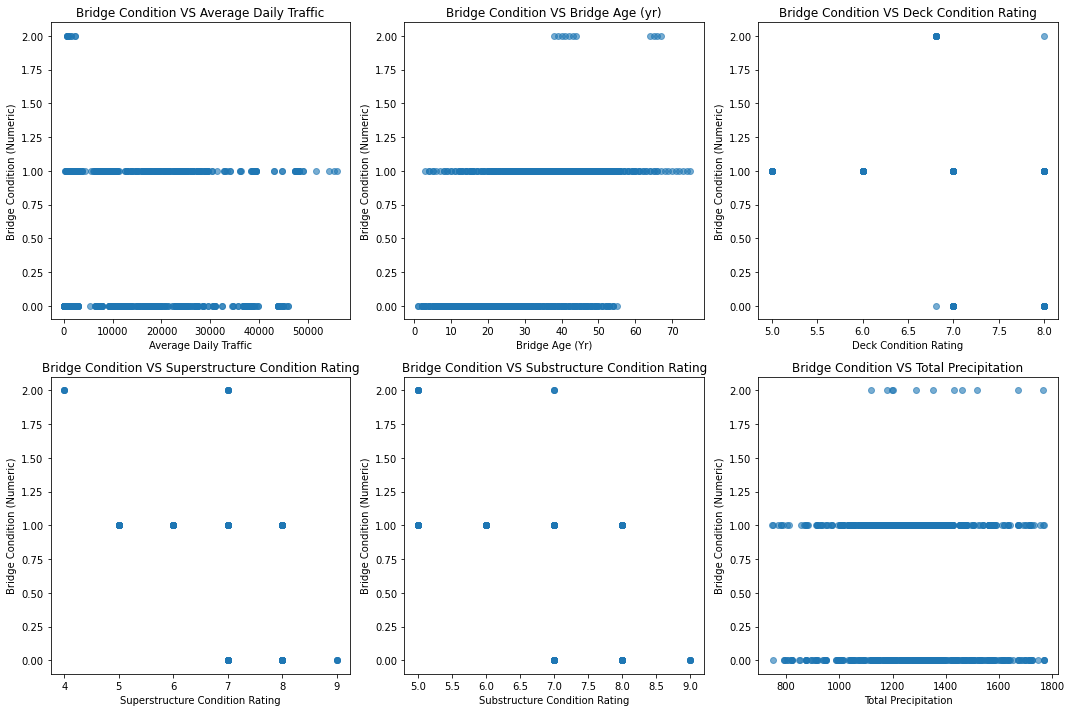

In [0]:
#Understanding correlation between Numerical Variables and Target Variable viz Bridge Condition
# Import libraries
import matplotlib.pyplot as plt
from pyspark.sql.functions import when

# Giving bridge condition to numeric values as 0, 1, 2 as in Good to 0, Fair to 1, Poor to 2)
df_bridgedata = df_bridgedata.withColumn(
    'Bridge_Condition_numeric',
    when(df_bridgedata['Bridge_Condition'] == 'Good', 0)
    .when(df_bridgedata['Bridge_Condition'] == 'Fair', 1)
    .when(df_bridgedata['Bridge_Condition'] == 'Poor', 2)
    .otherwise(None)  
)

#Visualize
nume_columns = ['Average_Daily_Traffic', 'Bridge_Age_(yr)', 'Deck_Condition_Rating',
                'Superstructure_Condition_Rating', 'Substructure_Condition_Rating', 'Total_Precipitation']

df_for_visualization = df_bridgedata.select(nume_columns + ['Bridge_Condition_numeric']).toPandas()

# Scatter plot
plt.figure(figsize=(15, 10))

for i, col in enumerate(nume_columns, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df_for_visualization[col], df_for_visualization['Bridge_Condition_numeric'], alpha=0.6)
    plt.title(f"Bridge Condition VS {col.replace('_', ' ')}")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel('Bridge Condition (Numeric)')

plt.tight_layout()
plt.show()

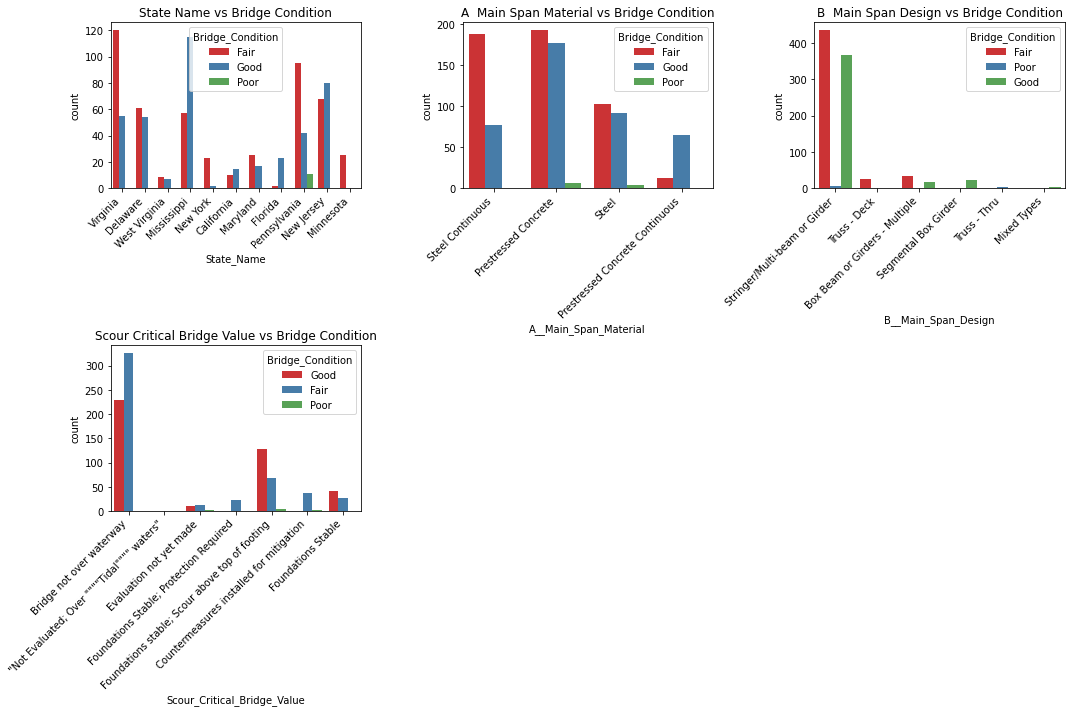

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Define variables and removing 'Facility_Carried_By_Structure'
categoric_columns = ['State_Name', 'A__Main_Span_Material', 'B__Main_Span_Design', 'Scour_Critical_Bridge_Value']

# Plot 
plt.figure(figsize=(15, 10))

for i, col in enumerate(categoric_columns, 1):
   
    plot_data = df_bridgedata.groupBy(col, 'Bridge_Condition').agg(F.count('*').alias('count'))
      
    plot_data_pd = plot_data.toPandas()

   
    plt.subplot(2, 3, i)
    sns.barplot(data=plot_data_pd, x=col, y='count', hue='Bridge_Condition', palette='Set1')
    plt.title(f"{col.replace('_', ' ')} vs Bridge Condition")
     
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


#Feature Selection

In [0]:
missing_values = df_bridgedata.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_bridgedata.columns])
missing_values.display()

Year,State_Name,Structure_Number,Owner_Agency,County_Name,Year_Built,Average_Daily_Traffic,A__Main_Span_Material,B__Main_Span_Design,Number_of_Spans_in_Main_Unit,Structure_Length_(ft),Facility_Carried_By_Structure,Bridge_Condition,Bridge_Age_(yr),Deck_Condition_Rating,Superstructure_Condition_Rating,Substructure_Condition_Rating,Scour_Critical_Bridge_Value,Average_Relative_Humidity,Average_Temperature,Maximum_Temperature,Mean_Wind_Speed,Minimum_Temperature,Number_of_FreezeThaw_Cycles,Number_of_Snowfall_Days,Number_of_Days_with_Measurable_Precipitation,Number_of_Days_with_Temperature_Below_0C,Prevailing_Wind_Direction,Time_of_Wetness,Total_Precipitation,Computed__Average_Daily_Truck_Traffic_(Volume),Operating_Rating_(US_tons),Inventory_Rating_(US_tons),Bridge_Condition_numeric
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Dropping rows with missing values
df_bridgedata = df_bridgedata.dropna()
missing_values = df_bridgedata.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_bridgedata.columns])
missing_values.display()

Year,State_Name,Structure_Number,Owner_Agency,County_Name,Year_Built,Average_Daily_Traffic,A__Main_Span_Material,B__Main_Span_Design,Number_of_Spans_in_Main_Unit,Structure_Length_(ft),Facility_Carried_By_Structure,Bridge_Condition,Bridge_Age_(yr),Deck_Condition_Rating,Superstructure_Condition_Rating,Substructure_Condition_Rating,Scour_Critical_Bridge_Value,Average_Relative_Humidity,Average_Temperature,Maximum_Temperature,Mean_Wind_Speed,Minimum_Temperature,Number_of_FreezeThaw_Cycles,Number_of_Snowfall_Days,Number_of_Days_with_Measurable_Precipitation,Number_of_Days_with_Temperature_Below_0C,Prevailing_Wind_Direction,Time_of_Wetness,Total_Precipitation,Computed__Average_Daily_Truck_Traffic_(Volume),Operating_Rating_(US_tons),Inventory_Rating_(US_tons),Bridge_Condition_numeric
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from pyspark.ml.feature import StringIndexer

cols_cat = [
    'State_Name', 'Owner_Agency', 'County_Name', 
    'A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 
    'Bridge_Condition', 'Scour_Critical_Bridge_Value', 'Prevailing_Wind_Direction', 'Time_of_Wetness'
]

cols_with_num = [
    'Average_Daily_Traffic', 'Operating_Rating_(US_tons)', 'Inventory_Rating_(US_tons)', 
    'Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 
    'Substructure_Condition_Rating', 'Average_Relative_Humidity', 'Average_Temperature', 
    'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature', 
    'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Total_Precipitation'
]

# Listing all categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df_bridgedata) for col in cols_cat]

# Giving indexers to data frame
df_encoded = df_bridgedata
for indexer in indexers:
    df_encoded = indexer.transform(df_encoded)

# Display the encoded schema
df_encoded.printSchema()

root
 |-- Year: double (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Structure_Number: string (nullable = true)
 |-- Owner_Agency: string (nullable = true)
 |-- County_Name: string (nullable = true)
 |-- Year_Built: double (nullable = true)
 |-- Average_Daily_Traffic: double (nullable = true)
 |-- A__Main_Span_Material: string (nullable = true)
 |-- B__Main_Span_Design: string (nullable = true)
 |-- Number_of_Spans_in_Main_Unit: double (nullable = true)
 |-- Structure_Length_(ft): double (nullable = true)
 |-- Facility_Carried_By_Structure: string (nullable = true)
 |-- Bridge_Condition: string (nullable = true)
 |-- Bridge_Age_(yr): double (nullable = true)
 |-- Deck_Condition_Rating: double (nullable = true)
 |-- Superstructure_Condition_Rating: double (nullable = true)
 |-- Substructure_Condition_Rating: double (nullable = true)
 |-- Scour_Critical_Bridge_Value: string (nullable = true)
 |-- Average_Relative_Humidity: double (nullable = true)
 |-- Average_Temperat

In [0]:
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
import numpy as np

In [0]:

#1: Drop if exists,'Bridge_Condition_index' column 
if 'Bridge_Condition_index' in df_encoded.columns:
    df_encoded = df_encoded.drop('Bridge_Condition_index')

#2: StringIndexer to target
# Note: df_encoded is already indexed, but we apply StringIndexer just to ensure 'Bridge_Condition' is correctly indexed
bridge_condition_indexer = StringIndexer(inputCol="Bridge_Condition", outputCol="Bridge_Condition_index")
df_indexed = bridge_condition_indexer.fit(df_encoded).transform(df_encoded)

#3: Drop if exists,'cat_features' column
if 'cat_features' in df_indexed.columns:
    df_indexed = df_indexed.drop('cat_features')

#4: categorical features assembled in single vector
assembler_cat = VectorAssembler(inputCols=[col + "_index" for col in cols_cat], outputCol="cat_features")
df_assembled_cat = assembler_cat.transform(df_indexed)

#5: Chi-Squared test for categorical features vs target variable
chi_square_test = ChiSquareTest.test(df_assembled_cat, 'cat_features', 'Bridge_Condition_index')

#6: results
chi_square_result = chi_square_test.head()

#7: get features based on p-value
significant_cat_features = [
    feature for feature, p_value in zip(cols_cat, chi_square_result.pValues) if p_value < 0.05
]

#8: Print
print("Significant Categorical Features based on Chi-Squared Test:")
print(significant_cat_features)

Significant Categorical Features based on Chi-Squared Test:
['State_Name', 'County_Name', 'A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 'Bridge_Condition', 'Scour_Critical_Bridge_Value']


In [0]:
from pyspark.ml.feature import StringIndexer

cols_cat = [
    'State_Name', 'Owner_Agency', 'County_Name', 
    'A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 
    'Bridge_Condition', 'Scour_Critical_Bridge_Value', 'Prevailing_Wind_Direction', 'Time_of_Wetness'
]

cols_with_num = [
    'Average_Daily_Traffic', 'Operating_Rating_(US_tons)', 'Inventory_Rating_(US_tons)', 
    'Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 
    'Substructure_Condition_Rating', 'Average_Relative_Humidity', 'Average_Temperature', 
    'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature', 
    'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Total_Precipitation'
]

# Listing categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df_bridgedata) for col in cols_cat]

# indexers to the data frame
df_encoded = df_bridgedata
for indexer in indexers:
    df_encoded = indexer.transform(df_encoded)

# encoded dataframe schema
df_encoded.printSchema()

root
 |-- Year: double (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Structure_Number: string (nullable = true)
 |-- Owner_Agency: string (nullable = true)
 |-- County_Name: string (nullable = true)
 |-- Year_Built: double (nullable = true)
 |-- Average_Daily_Traffic: double (nullable = true)
 |-- A__Main_Span_Material: string (nullable = true)
 |-- B__Main_Span_Design: string (nullable = true)
 |-- Number_of_Spans_in_Main_Unit: double (nullable = true)
 |-- Structure_Length_(ft): double (nullable = true)
 |-- Facility_Carried_By_Structure: string (nullable = true)
 |-- Bridge_Condition: string (nullable = true)
 |-- Bridge_Age_(yr): double (nullable = true)
 |-- Deck_Condition_Rating: double (nullable = true)
 |-- Superstructure_Condition_Rating: double (nullable = true)
 |-- Substructure_Condition_Rating: double (nullable = true)
 |-- Scour_Critical_Bridge_Value: string (nullable = true)
 |-- Average_Relative_Humidity: double (nullable = true)
 |-- Average_Temperat

In [0]:
# Total features 
total_features = len(cols_cat) + len(cols_with_num)

# Categorical count 
categorical_count = len(cols_cat)

# Numerical count  
numerical_count = len(cols_with_num)

# Display results
print(f"Total Features: {total_features}")
print(f"Categorical Features: {categorical_count}")
print(f"Numerical Features: {numerical_count}")

Total Features: 25
Categorical Features: 10
Numerical Features: 15


In [0]:
#1: numerical features into a vector assembler
assembler_num = VectorAssembler(inputCols=cols_with_num, outputCol="num_features")
df_assembled_num = assembler_num.transform(df_encoded)  # df_encoded contains both categorical and numerical features

#2: logistic regression model
lr = LogisticRegression(featuresCol="num_features", labelCol="Bridge_Condition_index", maxIter=10)
model_lr = lr.fit(df_assembled_num)

#3: coefficient matrix 
coeff_matrix = model_lr.coefficientMatrix
coeff_array = coeff_matrix.toArray()

#4: importance score
importance_scores_lr = np.abs(coeff_array).sum(axis=0)

#5: set threshold to get important numerical features
threshold = 0.1  
numerical_important_features = [
    feature for feature, importance in zip(cols_with_num, importance_scores_lr) if importance > threshold
]

#6: numerical non-selected features
numerical_non_selected_features = [
    feature for feature, importance in zip(cols_with_num, importance_scores_lr) if importance <= threshold
]

#7: Print coefficients
print("Important Numerical Features based on Logistic Regression Coefficients:")
print(numerical_important_features)

#8: count of all features
total_initial_features = len(cols_with_num)
selected_features_count = len(numerical_important_features)
dropped_features_count = len(numerical_non_selected_features)

print("\nTotal Initial Neumerical Features: ", total_initial_features)
print("Total Selected Neumerical Features: ", selected_features_count)
print("Dropped/Non-Selected Neumerical Features: ", dropped_features_count)

#9: non-selected features
print("\nDropped/Non-Selected Features:")
print(numerical_non_selected_features)

Important Numerical Features based on Logistic Regression Coefficients:
['Inventory_Rating_(US_tons)', 'Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 'Substructure_Condition_Rating', 'Average_Relative_Humidity', 'Average_Temperature', 'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature']

Total Initial Neumerical Features:  15
Total Selected Neumerical Features:  10
Dropped/Non-Selected Neumerical Features:  5

Dropped/Non-Selected Features:
['Average_Daily_Traffic', 'Operating_Rating_(US_tons)', 'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Total_Precipitation']


In [0]:
#1: all features into a vector assembler
assembler_all = VectorAssembler(inputCols=cols_with_num + [col + "_index" for col in cols_cat], outputCol="all_features")
df_assembled_all = assembler_all.transform(df_assembled_cat)

#2: RandomForest 
rf = RandomForestClassifier(featuresCol="all_features", labelCol="Bridge_Condition_index", numTrees=10, maxBins=500)
model_rf = rf.fit(df_assembled_all)

#3: feature importance
rf_importances = model_rf.featureImportances.toArray()

#4: resulting the significant features
threshold_rf = 0.05
random_forest_important_features = [
    feature for feature, importance in zip(cols_with_num + [col + "_index" for col in cols_cat], rf_importances)
    if importance > threshold_rf
]

#5: non-selected features that are under the threshold
random_forest_non_selected_features = [
    feature for feature, importance in zip(cols_with_num + [col + "_index" for col in cols_cat], rf_importances)
    if importance <= threshold_rf
]

#6: Display
print("Important Features based on Random Forest Feature Importances:")
print(random_forest_important_features)

#7
total_initial_features = len(cols_with_num + [col + "_index" for col in cols_cat])
selected_features_count = len(random_forest_important_features)
dropped_features_count = len(random_forest_non_selected_features)

print("\nTotal Initial Features: ", total_initial_features)
print("Selected Features Count: ", selected_features_count)
print("Dropped/Non-Selected Features Count: ", dropped_features_count)

#8
print("\nDropped/Non-Selected Features:")
print(random_forest_non_selected_features)

Important Features based on Random Forest Feature Importances:
['Bridge_Age_(yr)', 'Deck_Condition_Rating', 'Superstructure_Condition_Rating', 'Substructure_Condition_Rating', 'Bridge_Condition_index']

Total Initial Features:  25
Selected Features Count:  5
Dropped/Non-Selected Features Count:  20

Dropped/Non-Selected Features:
['Average_Daily_Traffic', 'Operating_Rating_(US_tons)', 'Inventory_Rating_(US_tons)', 'Average_Relative_Humidity', 'Average_Temperature', 'Maximum_Temperature', 'Mean_Wind_Speed', 'Minimum_Temperature', 'Number_of_FreezeThaw_Cycles', 'Number_of_Snowfall_Days', 'Total_Precipitation', 'State_Name_index', 'Owner_Agency_index', 'County_Name_index', 'A__Main_Span_Material_index', 'B__Main_Span_Design_index', 'Facility_Carried_By_Structure_index', 'Scour_Critical_Bridge_Value_index', 'Prevailing_Wind_Direction_index', 'Time_of_Wetness_index']


In [0]:
# Combining all features from Chi-Squared, Logistic Regression, and Random Forest method
final_selected_features = set(significant_cat_features + numerical_important_features + random_forest_important_features)

# Print
print("\nFinal Set of Selected Features:")
print(final_selected_features)

#Form a new DataFrame
final_features_df = df_assembled_cat.select(list(final_selected_features))

#1:total features both categorical and numerical
total_cat_features = len(cols_cat)
total_num_features = len(cols_with_num)

#2:selected features from each method
selected_cat_features_chi_squared = len(significant_cat_features)
selected_num_features_lr = len(numerical_important_features)
selected_features_rf = len(random_forest_important_features)

#3:dropped features
dropped_cat_features_chi_squared = total_cat_features - selected_cat_features_chi_squared
dropped_num_features_lr = total_num_features - selected_num_features_lr
dropped_features_rf = len(cols_with_num + [col + "_index" for col in cols_cat]) - selected_features_rf

#4: Display
print("\nFeature Selection Breakdown:")
print(f"Total Categorical Features: {total_cat_features}")
print(f"Total Numerical Features: {total_num_features}")

print("\nSelected Features (by method):")
print(f"Selected Categorical Features by Chi-Squared: {selected_cat_features_chi_squared}")
print(f"Selected Numerical Features by Logistic Regression: {selected_num_features_lr}")
print(f"Selected Features by Random Forest: {selected_features_rf}")

# Total features after combining 3 methods
final_selected_cat_features = [feature for feature in significant_cat_features if feature in final_selected_features]
final_selected_num_features = [feature for feature in numerical_important_features if feature in final_selected_features]
final_selected_rf_features = [feature for feature in random_forest_important_features if feature in final_selected_features]

# Display total features
final_selected_count = len(final_selected_features)
final_selected_cat_count = len(final_selected_cat_features)
final_selected_num_count = len(final_selected_num_features)
final_selected_rf_count = len(final_selected_rf_features)

print("\nFinal Selected Features Count After Combining Methods:")
print(f"Total Selected Features: {final_selected_count}")
print(f"Selected Categorical Features: {final_selected_cat_count}")
print(f"Selected Numerical Features: {final_selected_num_count}")
print(f"Selected Random Forest Features: {final_selected_rf_count}")

# Showing which features were dropped
dropped_features = set(
    list(
        set(cols_cat) - set(final_selected_cat_features)
    ) + list(
        set(cols_with_num) - set(final_selected_num_features)
    ) + list(
        set([col + "_index" for col in cols_cat]) - set(final_selected_rf_features)
    )
)

# Display and count dropped features
print("\nDropped/Non-Selected Features:")
print(dropped_features)
dropped_count = len(dropped_features)
print(f"Total Dropped Features: {dropped_count}")


Final Set of Selected Features:
{'Bridge_Age_(yr)', 'Average_Temperature', 'Bridge_Condition', 'State_Name', 'Deck_Condition_Rating', 'Maximum_Temperature', 'Minimum_Temperature', 'Bridge_Condition_index', 'Mean_Wind_Speed', 'County_Name', 'Superstructure_Condition_Rating', 'B__Main_Span_Design', 'Substructure_Condition_Rating', 'Facility_Carried_By_Structure', 'Scour_Critical_Bridge_Value', 'Inventory_Rating_(US_tons)', 'Average_Relative_Humidity', 'A__Main_Span_Material'}

Feature Selection Breakdown:
Total Categorical Features: 10
Total Numerical Features: 15

Selected Features (by method):
Selected Categorical Features by Chi-Squared: 7
Selected Numerical Features by Logistic Regression: 10
Selected Features by Random Forest: 5

Final Selected Features Count After Combining Methods:
Total Selected Features: 18
Selected Categorical Features: 7
Selected Numerical Features: 10
Selected Random Forest Features: 5

Dropped/Non-Selected Features:
{'Total_Precipitation', 'Facility_Carried

In [0]:
#Display dataframe with final set of features 
final_features_df.display()

Bridge_Age_(yr),Average_Temperature,Bridge_Condition,State_Name,Deck_Condition_Rating,Maximum_Temperature,Minimum_Temperature,Bridge_Condition_index,Mean_Wind_Speed,County_Name,Superstructure_Condition_Rating,B__Main_Span_Design,Substructure_Condition_Rating,Facility_Carried_By_Structure,Scour_Critical_Bridge_Value,Inventory_Rating_(US_tons),Average_Relative_Humidity,A__Main_Span_Material
58.0,13.79,Fair,Minnesota,6.0,40.5,-12.68,0.0,4.0,Pine County,5.0,Truss - Deck,7.0,TH 123,Countermeasures installed for mitigation,36.0,76.17,Steel Continuous
27.0,12.8,Fair,Delaware,7.0,35.5,-14.9,0.0,3.0,New Castle County,6.0,Stringer/Multi-beam or Girder,6.0,CHRISTINA PARKWAY,Foundations stable; Scour above top of footing,56.7,76.0,Steel Continuous
39.0,13.79,Fair,New Jersey,6.0,36.31,-12.68,0.0,1.81,Monmouth County,7.0,Stringer/Multi-beam or Girder,7.0,WEST BANGS AVENUE,Bridge not over waterway,21.1,76.17,Prestressed Concrete
19.0,13.9,Good,Delaware,7.0,39.0,-11.4,1.0,3.0,Kent County,7.0,Stringer/Multi-beam or Girder,7.0,KOREAN WAR VET HGW,Bridge not over waterway,55.0,78.0,Steel
42.0,13.2,Fair,Virginia,7.0,38.2,-15.8,0.0,2.0,Prince William County,5.0,Stringer/Multi-beam or Girder,5.0,WBL ROUTE 0066,Bridge not over waterway,68.0,71.0,Prestressed Concrete
37.0,13.79,Fair,New Jersey,6.0,36.31,-12.68,0.0,1.81,Monmouth County,6.0,Stringer/Multi-beam or Girder,7.0,NJ ROUTE 18 NB,Bridge not over waterway,38.0,76.17,Prestressed Concrete
43.0,13.79,Good,Mississippi,7.0,33.4,0.1,1.0,3.0,Harrison County,7.0,Stringer/Multi-beam or Girder,8.0,I 10,Bridge not over waterway,61.5,78.0,Prestressed Concrete
20.0,11.4,Good,Delaware,7.0,32.8,-18.5,1.0,3.0,New Castle County,8.0,Stringer/Multi-beam or Girder,8.0,KOREAN WAR VET MEM,Foundations stable; Scour above top of footing,73.3,78.0,Prestressed Concrete
29.0,13.2,Fair,Virginia,7.0,37.9,-15.1,0.0,2.0,Loudoun County,6.0,Stringer/Multi-beam or Girder,7.0,ROUTE 7 BYPASS,Foundations stable; Scour above top of footing,83.6,74.0,Steel
49.0,11.1,Good,Pennsylvania,8.0,33.8,-18.0,1.0,1.0,Dauphin County,7.0,Stringer/Multi-beam or Girder,7.0,T-494/SCHOOL HS RD,Bridge not over waterway,36.0,82.0,Steel Continuous


#Data Modelling, Results and Cross Validation

(1) Gradient Boosted Trees

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName("GoodVsNotGoodModel").getOrCreate()

df_gradientBoost = final_features_df.toDF(*[c.strip().replace(" ", "_").replace(".", "").lower() for c in final_features_df.columns])

# Mapping target variable for binary classification (good vs. not good)
df_gradientBoost = df_gradientBoost.withColumn(
    "bridge_condition_binary",
    when(col("bridge_condition_index") == 1, 1).otherwise(0)
)

# Environmental features
environmental_features = [
    "average_temperature", "maximum_temperature", "minimum_temperature",
    "mean_wind_speed", "average_relative_humidity"
]

assembler = VectorAssembler(inputCols=environmental_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Defining the Gradient Boosted Trees classifier
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="bridge_condition_binary", maxIter=50)

pipeline = Pipeline(stages=[assembler, scaler, gbt])

# Splitting data into training and test sets
train_data, test_data = df_gradientBoost.randomSplit([0.8, 0.2], seed=42)

# Model Fitting
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluating the model
evaluator = BinaryClassificationEvaluator(labelCol="bridge_condition_binary", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC Score: {roc_auc}")

# Extracting feature importance from the trained model
gbt_model = model.stages[-1] 
feature_importances = gbt_model.featureImportances

# Mapping feature importance to feature names
features_with_importance = [(environmental_features[i], importance) for i, importance in enumerate(feature_importances)]
features_with_importance = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for feature, importance in features_with_importance:
    print(f"{feature}: {importance}")


ROC-AUC Score: 0.7417366946778712

Feature Importance:
minimum_temperature: 0.25995209362777355
maximum_temperature: 0.2332859232641146
average_relative_humidity: 0.19955555510824463
average_temperature: 0.19770700180119147
mean_wind_speed: 0.1094994261986758


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="bridge_condition_binary", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# Confusion Matrix
confusion_matrix = predictions.groupBy("bridge_condition_binary", "prediction").count()

print("\nConfusion Matrix:")
confusion_matrix.show()

confusion_matrix_pivot = confusion_matrix.groupBy("bridge_condition_binary") \
    .pivot("prediction", [0, 1]) \
    .agg(F.first("count"))

print("\nFormatted Confusion Matrix:")
confusion_matrix_pivot.show()


F1 Score: 0.6677519899710791

Confusion Matrix:
+-----------------------+----------+-----+
|bridge_condition_binary|prediction|count|
+-----------------------+----------+-----+
|                      1|       0.0|   26|
|                      0|       0.0|   62|
|                      1|       1.0|   37|
|                      0|       1.0|   23|
+-----------------------+----------+-----+


Formatted Confusion Matrix:
+-----------------------+---+---+
|bridge_condition_binary|  0|  1|
+-----------------------+---+---+
|                      1| 26| 37|
|                      0| 62| 23|
+-----------------------+---+---+



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName("ComprehensiveBridgeModelWithSpanMaterial").getOrCreate()

# Cleaning column names
df_gradient_boost = final_features_df.toDF(*[c.strip().replace(" ", "_").replace(".", "").lower() for c in final_features_df.columns])

# Target variable for binary classification (good vs. not good)
df_gradient_boost = df_gradient_boost.withColumn(
    "bridge_condition_binary",
    when(col("bridge_condition_index") == 1, 1).otherwise(0)
)

# Environmental features
environmental_features = [
    "average_temperature", "maximum_temperature", "minimum_temperature",
    "mean_wind_speed", "average_relative_humidity"
]

# Structural features
structural_features = [
    "deck_condition_rating", "superstructure_condition_rating",
    "substructure_condition_rating", "inventory_rating_(us_tons)", "bridge_age_(yr)"
]

# Categorical features
categorical_features = ["scour_critical_bridge_value", "state_name", "county_name", "a__main_span_material"]

# Encoding categorical variables
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="skip") for c in categorical_features]

# Combining all features
all_features = environmental_features + structural_features + [f"{c}_index" for c in categorical_features]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="bridge_condition_binary", maxIter=50)
pipeline = Pipeline(stages=indexers + [assembler, scaler, gbt])

# Splitting data into training and test sets
train_data, test_data = df_gradient_boost.randomSplit([0.8, 0.2], seed=42)

# Model Fitting
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Model Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="bridge_condition_binary", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC Score: {roc_auc}")

# Extracting feature importance from the trained model
gbt_model = model.stages[-1] 
feature_importances = gbt_model.featureImportances

# Feature importance to feature names
features_with_importance = [(all_features[i], importance) for i, importance in enumerate(feature_importances)]
features_with_importance = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for feature, importance in features_with_importance:
    print(f"{feature}: {importance}")

ROC-AUC Score: 0.9957049486461251

Feature Importance:
superstructure_condition_rating: 0.4782557696255237
deck_condition_rating: 0.37213822803688223
substructure_condition_rating: 0.14960600233759358
bridge_age_(yr): 2.792135851468705e-16
mean_wind_speed: 9.602583616162215e-17
scour_critical_bridge_value_index: 3.944907548082027e-17
state_name_index: 3.8779664603732016e-17
a__main_span_material_index: 1.588119598057597e-17
average_temperature: 7.386602781663259e-18
maximum_temperature: 0.0
minimum_temperature: 0.0
average_relative_humidity: 0.0
inventory_rating_(us_tons): 0.0
county_name_index: 0.0


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="bridge_condition_binary", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# Confusion Matrix
confusion_matrix = predictions.groupBy("bridge_condition_binary", "prediction").count()

print("\nConfusion Matrix:")
confusion_matrix.show()
confusion_matrix_pivot = confusion_matrix.groupBy("bridge_condition_binary") \
    .pivot("prediction", [0, 1]) \
    .agg(F.first("count"))

print("\nFormatted Confusion Matrix:")
confusion_matrix_pivot.show()


F1 Score: 0.9932359728149203

Confusion Matrix:
+-----------------------+----------+-----+
|bridge_condition_binary|prediction|count|
+-----------------------+----------+-----+
|                      1|       0.0|    1|
|                      0|       0.0|   85|
|                      1|       1.0|   62|
+-----------------------+----------+-----+


Formatted Confusion Matrix:
+-----------------------+---+----+
|bridge_condition_binary|  0|   1|
+-----------------------+---+----+
|                      1|  1|  62|
|                      0| 85|null|
+-----------------------+---+----+



Regions: ['Minnesota', 'Pennsylvania', 'Delaware', 'West Virginia', 'Virginia', 'New Jersey', 'Maryland', 'Mississippi', 'Florida', 'California', 'New York']

Training model for region: Minnesota
Skipping region Minnesota due to insufficient data.

Training model for region: Pennsylvania
Region: Pennsylvania, ROC-AUC: 1.0, F1 Score: 1.0

Training model for region: Delaware
Region: Delaware, ROC-AUC: 1.0, F1 Score: 1.0

Training model for region: West Virginia
Skipping region West Virginia due to insufficient data.

Training model for region: Virginia
Region: Virginia, ROC-AUC: 1.0, F1 Score: 1.0

Training model for region: New Jersey
Region: New Jersey, ROC-AUC: 1.0, F1 Score: 1.0

Training model for region: Maryland
Skipping region Maryland due to insufficient data.

Training model for region: Mississippi
Region: Mississippi, ROC-AUC: 0.9444444444444444, F1 Score: 0.9649235640429427

Training model for region: Florida
Skipping region Florida due to insufficient data.

Training model f

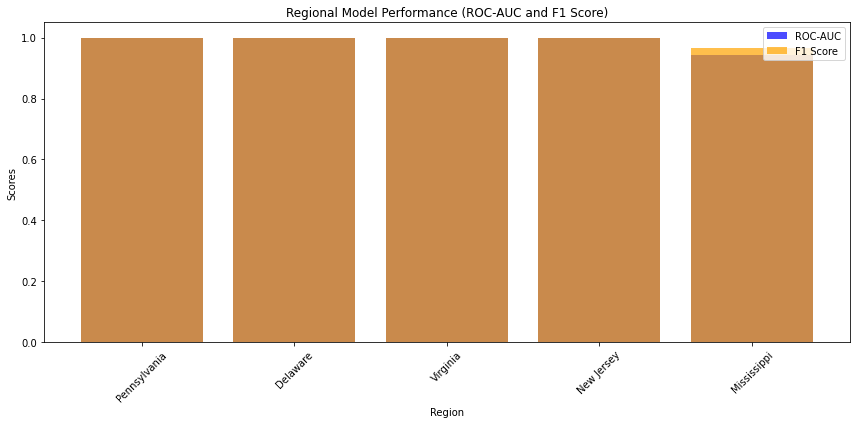

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Initialize metrics storage
region_metrics = []

# List of states/regions
regions = [row['state_name'] for row in final_features_df.select("state_name").distinct().collect()]
print(f"Regions: {regions}")

# Loop through each region for analysis
for region in regions:
    print(f"\nTraining model for region: {region}")
    
    # Filter data for the region
    region_data = df_gradientBoost.filter(F.col("state_name") == region)
    
    # Skip regions with insufficient data
    if region_data.count() < 50:
        print(f"Skipping region {region} due to insufficient data.")
        continue
    
    # Split region-specific data
    train_data, test_data = region_data.randomSplit([0.8, 0.2], seed=42)
    
    # Train the pipeline model
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    
    # Evaluate ROC-AUC
    roc_auc = evaluator.evaluate(predictions)
    
    # Evaluate F1 Score
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="bridge_condition_binary", predictionCol="prediction", metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)
    
    # Append metrics to the region metrics list
    region_metrics.append((region, roc_auc, f1_score))
    print(f"Region: {region}, ROC-AUC: {roc_auc}, F1 Score: {f1_score}")

# Convert performance metrics to a DataFrame for comparison
region_metrics_df = spark.createDataFrame(region_metrics, ["Region", "ROC_AUC", "F1_Score"])
region_metrics_df.show()

# Convert to Pandas for visualization
region_metrics_pd = region_metrics_df.toPandas()

# Plot the Regional Model Performance (ROC-AUC and F1 Score)
plt.figure(figsize=(12, 6))
plt.bar(region_metrics_pd['Region'], region_metrics_pd['ROC_AUC'], alpha=0.7, label='ROC-AUC', color='blue')
plt.bar(region_metrics_pd['Region'], region_metrics_pd['F1_Score'], alpha=0.7, label='F1 Score', color='orange')
plt.xlabel('Region')
plt.ylabel('Scores')
plt.title('Regional Model Performance (ROC-AUC and F1 Score)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

(2) Random Forest Classifier

Model Accuracy: 0.99
Feature Importances:
                            Feature  Importance
2  Superstructure_Condition_Rating    0.421665
1            Deck_Condition_Rating    0.325998
3    Substructure_Condition_Rating    0.216690
0                  Bridge_Age_(yr)    0.027526
4       Inventory_Rating_(US_tons)    0.008121


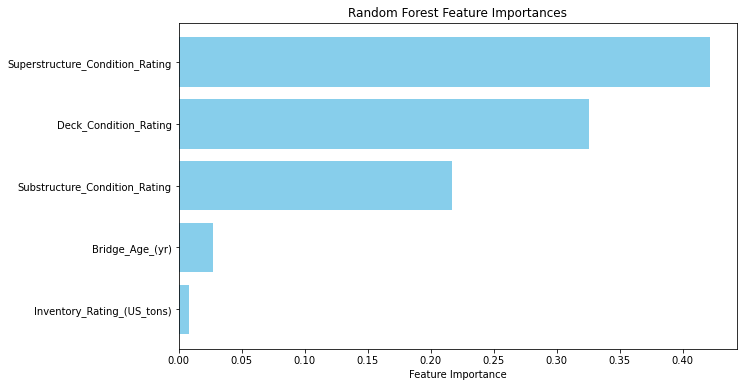

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define Risk Levels
final_features_df = final_features_df.withColumn(
    "Risk Level",
    when((col("Bridge_Condition") == "Fair") | (col("Bridge_Condition") == "Poor"), "High Risk").otherwise("Low Risk")
)

# Step 2: Encode Risk Levels as Binary Index
indexer = StringIndexer(inputCol="Risk Level", outputCol="RiskLevelIndex")
final_features_df = indexer.fit(final_features_df).transform(final_features_df)

# Step 3: Assemble Features
selected_features = [
    "Bridge_Age_(yr)", "Deck_Condition_Rating", "Superstructure_Condition_Rating",
    "Substructure_Condition_Rating",
    "Inventory_Rating_(US_tons)"
]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Step 4: Train-Test Split
train_data, test_data = final_features_df.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train Random Forest Classifier
rf = RandomForestClassifier(labelCol="RiskLevelIndex", featuresCol="features", numTrees=45, seed=41)
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train_data)

# Step 6: Make Predictions
predictions = model.transform(test_data)

# Step 7: Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.2f}")

# Step 8: Feature Importance
rf_model = model.stages[-1]  # Random Forest model
importances = rf_model.featureImportances.toArray()
features_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display Feature Importances
print("Feature Importances:\n", features_df)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(features_df["Feature"], features_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()



Condition ratings,structural components (superstructure, deck, and substructure) are critical for predicting bridge condition and should be the focus in prioritization models.
Bridge age and inventory ratings have negligible impact on the model, indicating they may not need prioritization in future models unless context suggests otherwise.
This insight can guide decision-making for bridge maintenance and risk assessment.

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# If the target variable is continuous (use regression evaluator)
regression_evaluator = RegressionEvaluator(labelCol="RiskLevelIndex", predictionCol="prediction")

# Calculate RMSE (Root Mean Square Error)
rmse = regression_evaluator.evaluate(predictions, {regression_evaluator.metricName: "rmse"})
print(f"RMSE: {rmse:.2f}")

# Calculate R² (Coefficient of Determination)
r2 = regression_evaluator.evaluate(predictions, {regression_evaluator.metricName: "r2"})
print(f"R²: {r2:.2f}")

# For classification metrics
classification_evaluator = MulticlassClassificationEvaluator(labelCol="RiskLevelIndex", predictionCol="prediction")

# Accuracy
accuracy = classification_evaluator.evaluate(predictions, {classification_evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy:.2f}")



RMSE: 0.08
R²: 0.97
Accuracy: 0.99


(3) Linear regression

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Selected the categorical columns
selected_features = ['A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 
                     'Scour_Critical_Bridge_Value', 'Bridge_Condition']

                     

# selected features
df_selected = df_bridgedata.select(selected_features)

# Index the target variable
indexer = StringIndexer(inputCol="Bridge_Condition", outputCol="label")
df_indexed = indexer.fit(df_selected).transform(df_selected)

categorical_features = ['A__Main_Span_Material', 'B__Main_Span_Design', 'Facility_Carried_By_Structure', 
                        'Scour_Critical_Bridge_Value']

# Index and one-hot encode 
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_features]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_encoded"]) for col in categorical_features]

# indexers and encoders in sequence
for indexer in indexers:
    df_indexed = indexer.fit(df_indexed).transform(df_indexed)

for encoder in encoders:
    df_indexed = encoder.fit(df_indexed).transform(df_indexed)

# Assemble all feature columns into a single vector
encoded_feature_columns = [col + "_encoded" for col in categorical_features]
assembler = VectorAssembler(inputCols=encoded_feature_columns, outputCol="features")
df_assembled = assembler.transform(df_indexed)


train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)

# linear regression model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)


predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


Root Mean Squared Error (RMSE) on test data = 0.33228279675002914


Root Mean Squared Error (RMSE): 0.33228279675002914


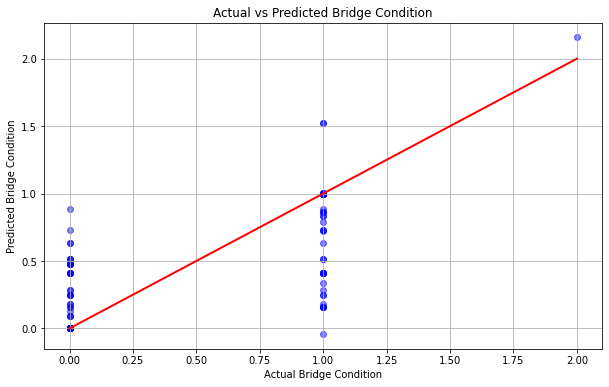

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Evaluate the model with RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Convert predictions to Pandas DataFrame for plotting
predictions_pd = predictions.select("label", "prediction").toPandas()

# Plot the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["label"], predictions_pd["prediction"], alpha=0.5, color="b")
plt.plot([predictions_pd["label"].min(), predictions_pd["label"].max()],
         [predictions_pd["label"].min(), predictions_pd["label"].max()],
         color="red", linewidth=2)  # Line for perfect prediction

plt.xlabel("Actual Bridge Condition")
plt.ylabel("Predicted Bridge Condition")
plt.title("Actual vs Predicted Bridge Condition")
plt.grid(True)
plt.show()


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# different metrics
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")


rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)


print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Root Mean Squared Error (RMSE): 0.33228279675002914
Mean Absolute Error (MAE): 0.1934423743760914
R-squared (R²): 0.580346813104472


In [0]:
# predictions on the test data
predictions = lr_model.transform(test_data)

# To display:features, label, and prediction
predictions.select("features", "label", "prediction").show(10)


+--------------------+-----+--------------------+
|            features|label|          prediction|
+--------------------+-----+--------------------+
|(65,[0,4,53,60],[...|  1.0|  0.3333269753857243|
|(65,[0,4,29,64],[...|  0.0|-3.58617073193512...|
|(65,[0,4,29,64],[...|  0.0|-3.58617073193512...|
|(65,[0,4,29,64],[...|  0.0|-3.58617073193512...|
|(65,[0,4,29,64],[...|  0.0|-3.58617073193512...|
|(65,[0,4,29,60],[...|  0.0|0.002478796433041275|
|(65,[0,3,10,59],[...|  0.0| 0.15789988416382372|
|(65,[0,3,10,59],[...|  0.0| 0.15789988416382372|
|(65,[0,3,10,59],[...|  1.0| 0.15789988416382372|
|(65,[0,3,10,59],[...|  1.0| 0.15789988416382372|
+--------------------+-----+--------------------+
only showing top 10 rows



In [0]:
# Get coefficients from the linear regression model
coefficients = lr_model.coefficients.toArray().tolist()  # Convert to a list of Python floats
intercept = lr_model.intercept

# intercept
print(f"Intercept: {intercept}")

# Create a DataFrame with feature names and their corresponding coefficients
feature_importance_df = spark.createDataFrame(zip(encoded_feature_columns, coefficients), ["Feature", "Coefficient"])
feature_importance_df = feature_importance_df.withColumn("Abs_Coefficient", F.abs("Coefficient"))
feature_importance_df = feature_importance_df.orderBy("Abs_Coefficient", ascending=False)

# Show the top features affecting bridge condition (sorted by absolute coefficient value)
print("Top features affecting bridge condition:")
feature_importance_df.show(truncate=False)

Intercept: 0.8102621913289803
Top features affecting bridge condition:
+-------------------------------------+---------------------+--------------------+
|Feature                              |Coefficient          |Abs_Coefficient     |
+-------------------------------------+---------------------+--------------------+
|Facility_Carried_By_Structure_encoded|-0.371860965136371   |0.371860965136371   |
|B__Main_Span_Design_encoded          |-0.054302649427427775|0.054302649427427775|
|A__Main_Span_Material_encoded        |0.05214024080117193  |0.05214024080117193 |
|Scour_Critical_Bridge_Value_encoded  |-9.660949901683666E-4|9.660949901683666E-4|
+-------------------------------------+---------------------+--------------------+



In [0]:
from pyspark.sql import functions as F

# calculate the average bridge condition for each material
influence_df = df_assembled.groupBy("A__Main_Span_Material") \
    .agg(F.avg("label").alias("Avg_Bridge_Condition"))

# Show the influence of each A__Main_Span_Material on the bridge condition
print("Influence of each A__Main_Span_Material on the bridge condition:")
influence_df.show(truncate=False)


Influence of each A__Main_Span_Material on the bridge condition:
+-------------------------------+--------------------+
|A__Main_Span_Material          |Avg_Bridge_Condition|
+-------------------------------+--------------------+
|Steel                          |0.5025125628140703  |
|Prestressed Concrete Continuous|0.8441558441558441  |
|Prestressed Concrete           |0.5066666666666667  |
|Steel Continuous               |0.29056603773584905 |
+-------------------------------+--------------------+



In [0]:
# Influence of each B__Main_Span_Design_encoded on the bridge condition
facility_influence_df = df_assembled.groupBy("B__Main_Span_Design") \
    .agg(F.avg("label").alias("Avg_Bridge_Condition"))

# Show the influence of each facility on the bridge condition
print("Influence of each B__Main_Span_Design_encoded on the bridge condition:")
facility_influence_df.show(truncate=False)


Influence of each B__Main_Span_Design_encoded on the bridge condition:
+------------------------------+--------------------+
|B__Main_Span_Design           |Avg_Bridge_Condition|
+------------------------------+--------------------+
|Stringer/Multi-beam or Girder |0.47095179233621753 |
|Mixed Types                   |1.0                 |
|Segmental Box Girder          |0.92                |
|Box Beam or Girders - Multiple|0.34                |
|Truss - Thru                  |2.0                 |
|Truss - Deck                  |0.0                 |
+------------------------------+--------------------+



In [0]:
# Influence of each Facility_Carried_By_Structure on the bridge condition
facility_influence_df = df_assembled.groupBy("Facility_Carried_By_Structure") \
    .agg(F.avg("label").alias("Avg_Bridge_Condition"))

# Show the influence of each facility on the bridge condition
print("Influence of each Facility_Carried_By_Structure on the bridge condition:")
facility_influence_df.show(truncate=False)


Influence of each Facility_Carried_By_Structure on the bridge condition:
+-----------------------------+--------------------+
|Facility_Carried_By_Structure|Avg_Bridge_Condition|
+-----------------------------+--------------------+
|DUPONT HWY                   |1.0                 |
|TH 123                       |0.0                 |
|PA 309 BY-PASS               |0.0                 |
|NJ 47                        |0.8181818181818182  |
|I 495 SB                     |0.0                 |
|NJ 18                        |0.0                 |
|I 10                         |1.0                 |
|PA 324;SR 0324               |0.72                |
|NJ ROUTE 133 EB              |1.0                 |
|SR-7 BYPASS WBL              |1.0                 |
|MN 123                       |0.0                 |
|EBL ROUTE 0066               |0.2                 |
|US 219 (SBL)                 |0.09090909090909091 |
|LEE CHAPEL ROAD              |1.0                 |
|CHRISTINA PARKWAY        

In [0]:
# Influence of each Scour_Critical_Bridge_Value on the bridge condition
scour_influence_df = df_assembled.groupBy("Scour_Critical_Bridge_Value") \
    .agg(F.avg("label").alias("Avg_Bridge_Condition"))

# Show the influence of each scour critical value on the bridge condition
print("Influence of each Scour_Critical_Bridge_Value on the bridge condition:")
scour_influence_df.show(truncate=False)


Influence of each Scour_Critical_Bridge_Value on the bridge condition:
+----------------------------------------------+--------------------+
|Scour_Critical_Bridge_Value                   |Avg_Bridge_Condition|
+----------------------------------------------+--------------------+
|"Not Evaluated; Over """"Tidal"""" waters"    |1.0                 |
|Evaluation not yet made                       |0.6538461538461539  |
|Foundations Stable                            |0.6231884057971014  |
|Foundations Stable; Protection Required       |0.0                 |
|Foundations stable; Scour above top of footing|0.675               |
|Countermeasures installed for mitigation      |0.14634146341463414 |
|Bridge not over waterway                      |0.4136690647482014  |
+----------------------------------------------+--------------------+



Root Mean Squared Error (RMSE) on test data using cross-validation = 0.32861599826701227


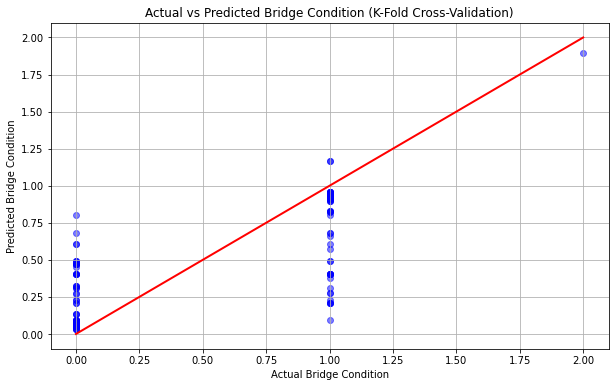

In [0]:
# crossvalidation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# hyperparameter tuning 
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.1])  # Regularization parameter
              .addGrid(lr.maxIter, [10])    # Number of iterations
              .build())

#  evaluator for RMSE 
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# CrossValidator for K-fold cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3) 

# Fit the model using cross-validation on the training data
cv_model = crossval.fit(train_data)


predictions = cv_model.transform(test_data)


rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data using cross-validation = {rmse}")

# Convert predictions to Pandas DataFrame for plotting (already defined earlier)
predictions_pd = predictions.select("label", "prediction").toPandas()

# Plot the predictions vs. actual values (already defined earlier)
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["label"], predictions_pd["prediction"], alpha=0.5, color="b")
plt.plot([predictions_pd["label"].min(), predictions_pd["label"].max()],
         [predictions_pd["label"].min(), predictions_pd["label"].max()],
         color="red", linewidth=2)  # Line for perfect prediction

plt.xlabel("Actual Bridge Condition")
plt.ylabel("Predicted Bridge Condition")
plt.title("Actual vs Predicted Bridge Condition (K-Fold Cross-Validation)")
plt.grid(True)
plt.show()
